# GCNのデモンストレーション
- Graph Neural Network(GCN)
- Coraネットワークを利用してリンク予測をする

GPUの動作確認

In [7]:
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Jul  3 2025, 17:03:59) [GCC 11.4.0]
PyTorch：2.7.1+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得

- CORAネットワーク
    - 論文索引関係を表すネットワーク

### 取得したCoraデータを変換

- CoraのテストデータをPyTorchのデータ型に変換
- 変換したデータ分割する

In [8]:
# networkxのグラフをtorch_geometricのDataに変換
from torch_geometric.datasets import Planetoid 
from torch_geometric.utils import (
    train_test_split_edges,
)

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None      # ノード分類用マスクは不要

# エッジをトレーニング、検証、テストセットに分割
data = train_test_split_edges(data)

print("Node Features:", data.x.shape)

Node Features: torch.Size([2708, 1433])


/app/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


### 取得したデータの可視化

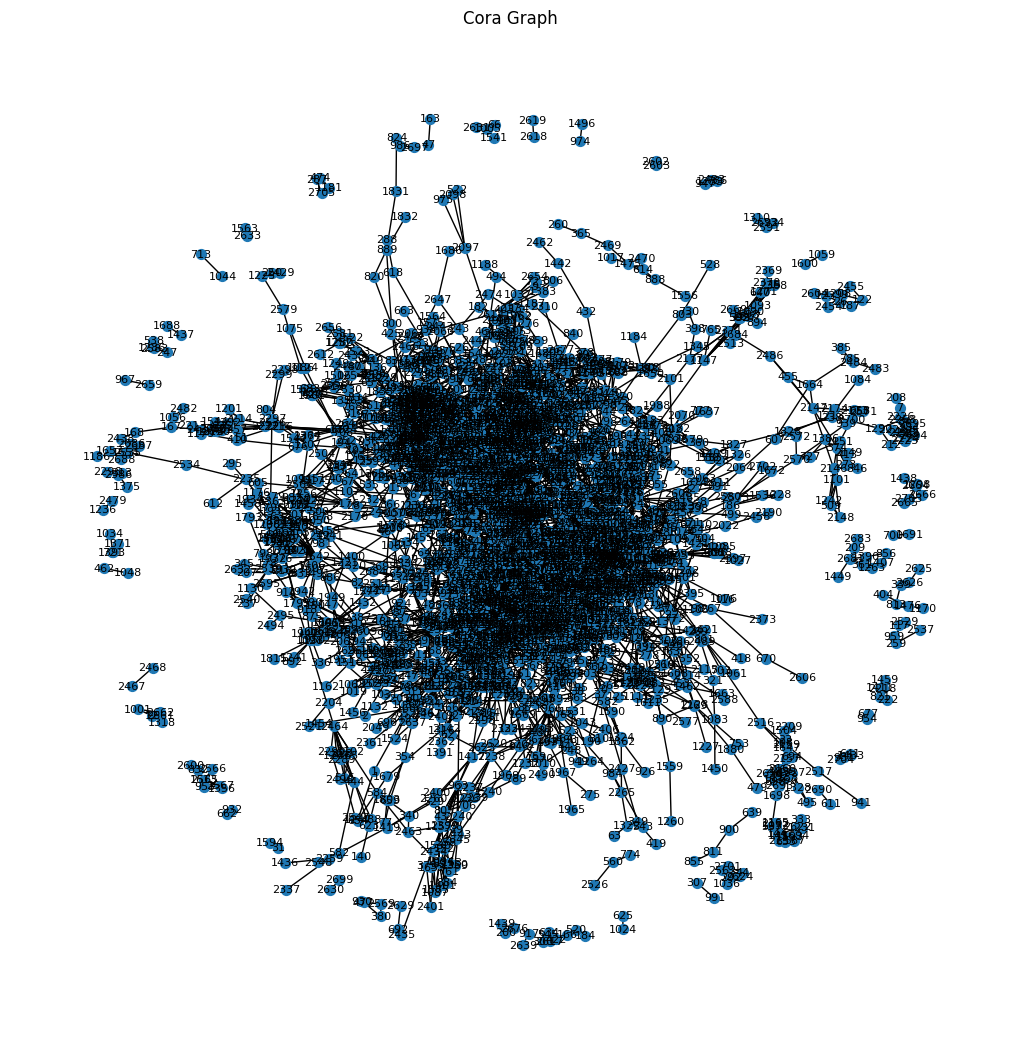

In [9]:
# データを可視化
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(data.train_pos_edge_index.t().tolist())

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Cora Graph")
plt.show()

## GCNを活用したリンク予測
- Graph Convolution Network(GCN)
- リンク予測：グラフにおける既存のエッジから新たなエッジを予測する

### GCNモデルの定義


In [10]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [11]:
# モデルの初期化
in_channels = data.num_node_features  # 特徴量の数
out_channels = 8  # 出力の次元数
model = GCN(in_channels, out_channels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # 利用するデバイスを選択
data = data.to(device)  # データも同じデバイスに移動

### モデルの学習
- パラメータの更新: Adam
- 目的関数
    - バイナリークロスエントロピー

In [12]:
# モデルの学習
epoch_num = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, epoch_num + 1):
    model.train()
    optimizer.zero_grad()

    # データをデバイスに移動
    x_device = data.x.to(device)
    train_pos_edge_index = data.train_pos_edge_index.to(device)
    
    # モデルの出力
    out = model(x_device, train_pos_edge_index)
    
    # 正のエッジをサンプリング
    num_pos_edges = train_pos_edge_index.size(1)
    pos_edge_index = train_pos_edge_index[:, :num_pos_edges]

    # 正のエッジのノード埋め込みを取得
    edge_embeddings_src = out[train_pos_edge_index[0]]
    edge_embeddings_dst = out[train_pos_edge_index[1]]
    pos_scores = torch.sum(edge_embeddings_src * edge_embeddings_dst, dim=1) # 内積でエッジの存在確率を計算
    
    # 負のエッジをサンプリング
    num_neg_edges = train_pos_edge_index.size(1)
    neg_edge_index = torch.randint(0, data.num_nodes, (2, num_neg_edges), device=device)
    
    # 負のエッジのノード埋め込みを取得
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    
    # ラベルを作成（正のエッジ=1、負のエッジ=0）
    pos_labels = torch.ones(pos_scores.size(0), device=device)
    neg_labels = torch.zeros(neg_scores.size(0), device=device)
    
    # スコアとラベルを結合
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels])
    
    # 損失計算（バイナリクロスエントロピー）
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 10, Loss: 0.6075
Epoch 20, Loss: 0.5269
Epoch 30, Loss: 0.4985
Epoch 40, Loss: 0.4882
Epoch 50, Loss: 0.4821
Epoch 60, Loss: 0.4690
Epoch 70, Loss: 0.4598
Epoch 80, Loss: 0.4587
Epoch 90, Loss: 0.4639
Epoch 100, Loss: 0.4542


### モデルの評価
- AUC評価

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score

# 学習済みモデルでリンク予測を実行
model.eval()
with torch.no_grad():
    # テストデータでの予測
    out = model(data.x.to(device), data.train_pos_edge_index.to(device))
    
    # テスト用正のエッジでの予測
    test_pos_edge_index = data.test_pos_edge_index.to(device)
    pos_embeddings_src = out[test_pos_edge_index[0]]
    pos_embeddings_dst = out[test_pos_edge_index[1]]
    pos_scores = torch.sum(pos_embeddings_src * pos_embeddings_dst, dim=1)
    pos_pred = torch.sigmoid(pos_scores)
    
    # テスト用負のエッジでの予測
    test_neg_edge_index = data.test_neg_edge_index.to(device)
    neg_embeddings_src = out[test_neg_edge_index[0]]
    neg_embeddings_dst = out[test_neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    neg_pred = torch.sigmoid(neg_scores)
    
    # 予測結果をまとめる
    predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy()
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).cpu().numpy()
    
    # AUCスコアを計算
    auc_score = roc_auc_score(labels, predictions)
    
    # 0.5を閾値として分類精度を計算
    binary_predictions = (predictions > 0.5).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)
    
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

AUC Score: 0.9044
Accuracy: 0.7600
Positive edge predictions (mean): 0.7979
Negative edge predictions (mean): 0.4990


### グラフの可視化

- 予測前のグラフと予測後のグラフを可視化し比較する

予測された正のエッジ数: 507
有効な予測エッジ数: 507


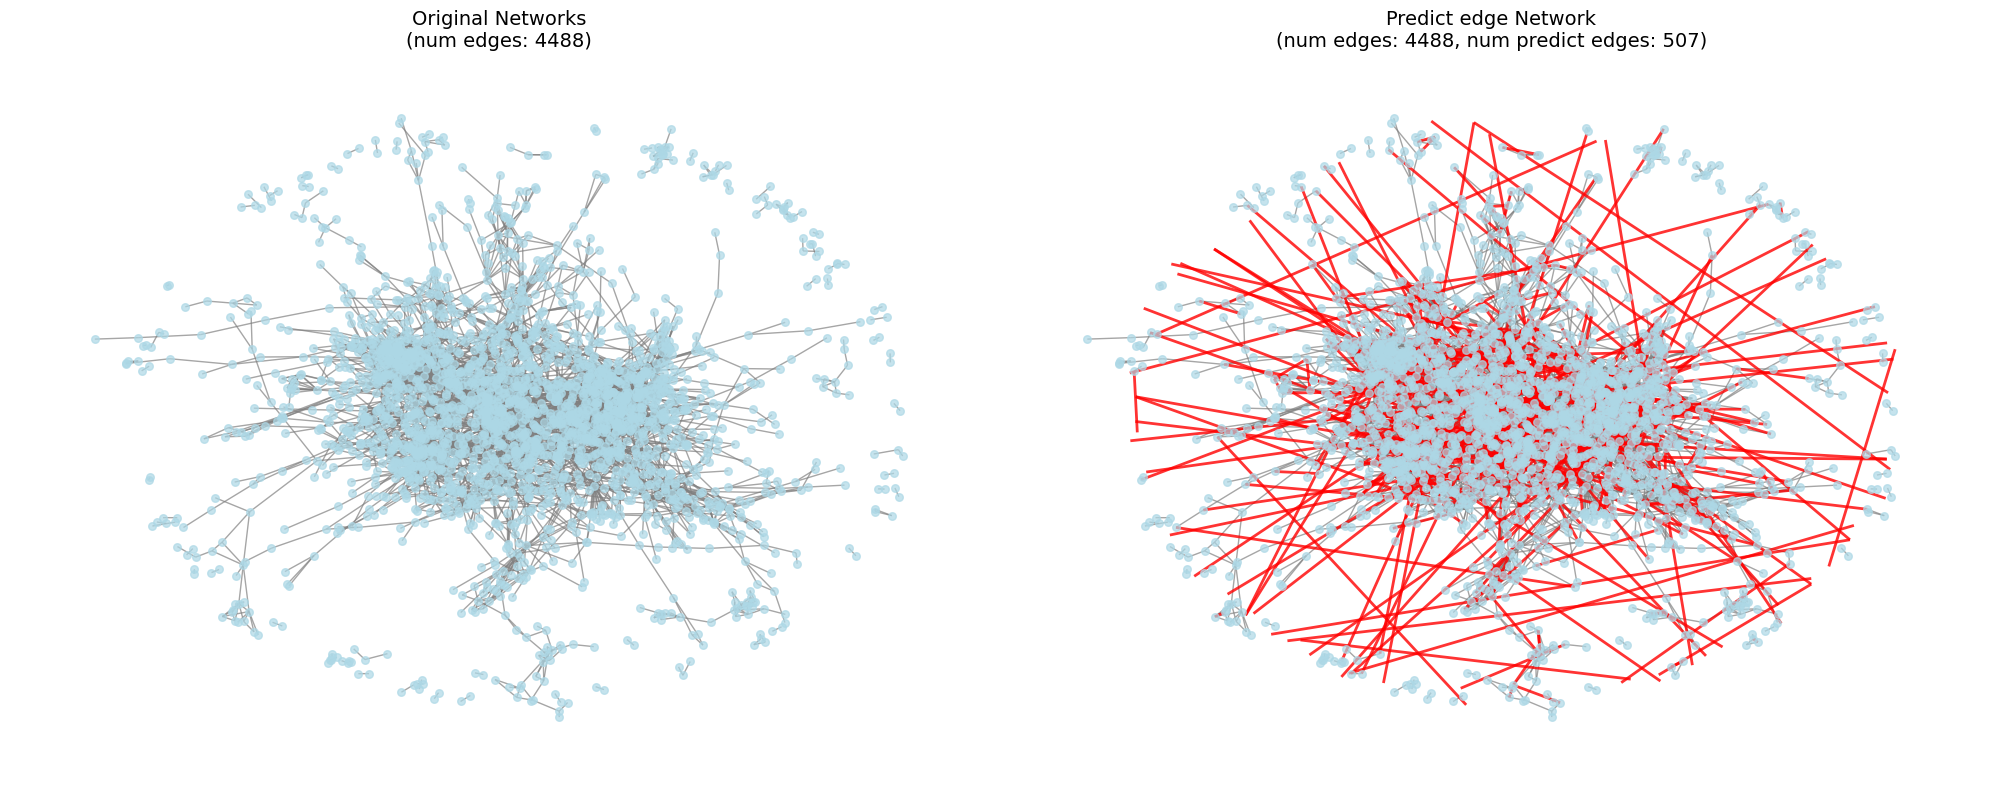


=== 予測結果サマリー ===
閾値 0.5 以上の予測エッジ数: 507
有効な予測エッジ数: 507
全テスト正エッジ数: 527


In [14]:
# リンク予測後のネットワークを可視化
import matplotlib.pyplot as plt

# 予測されたエッジを取得（閾値0.5以上のもの）
threshold = 0.5
predicted_edges = []

# 正のエッジの予測結果から閾値以上のものを取得
for i, score in enumerate(pos_pred.cpu().numpy()):
    if score >= threshold:
        edge = test_pos_edge_index[:, i].cpu().numpy()
        predicted_edges.append((edge[0], edge[1]))

print(f"予測された正のエッジ数: {len(predicted_edges)}")

# 元のトレーニングエッジでグラフを作成
G_original = nx.Graph()
G_original.add_edges_from(data.train_pos_edge_index.t().cpu().numpy())

# 全ノードを含むグラフを作成（孤立ノードも含む）
G_full = nx.Graph()
G_full.add_nodes_from(range(data.num_nodes))  # 全ノードを追加
G_full.add_edges_from(data.train_pos_edge_index.t().cpu().numpy())

# レイアウトを全ノードで計算
pos = nx.spring_layout(G_full, seed=42)

# 予測エッジのうち、レイアウトに存在するもののみをフィルタリング
valid_predicted_edges = []
for edge in predicted_edges:
    if edge[0] in pos and edge[1] in pos:
        valid_predicted_edges.append(edge)

print(f"有効な予測エッジ数: {len(valid_predicted_edges)}")

# 可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 元のネットワーク
nx.draw(G_original, pos, ax=ax1, with_labels=False, node_size=30, 
        node_color='lightblue', edge_color='gray', alpha=0.7)
ax1.set_title(f"Original Networks\n(num edges: {G_original.number_of_edges()})", fontsize=14)

# 予測エッジを追加したネットワーク
nx.draw(G_original, pos, ax=ax2, with_labels=False, node_size=30, 
        node_color='lightblue', edge_color='gray', alpha=0.7)

# 有効な予測エッジのみを赤色で追加
if valid_predicted_edges:
    nx.draw_networkx_edges(G_full, pos, edgelist=valid_predicted_edges, 
                          ax=ax2, edge_color='red', width=2, alpha=0.8)

ax2.set_title(f"Predict edge Network\n(num edges: {G_original.number_of_edges()}, num predict edges: {len(valid_predicted_edges)})", fontsize=14)

plt.tight_layout()
plt.show()

# 予測精度の詳細表示
print(f"\n=== 予測結果サマリー ===")
print(f"閾値 {threshold} 以上の予測エッジ数: {len(predicted_edges)}")
print(f"有効な予測エッジ数: {len(valid_predicted_edges)}")
print(f"全テスト正エッジ数: {len(pos_pred)}")